Report

KNN
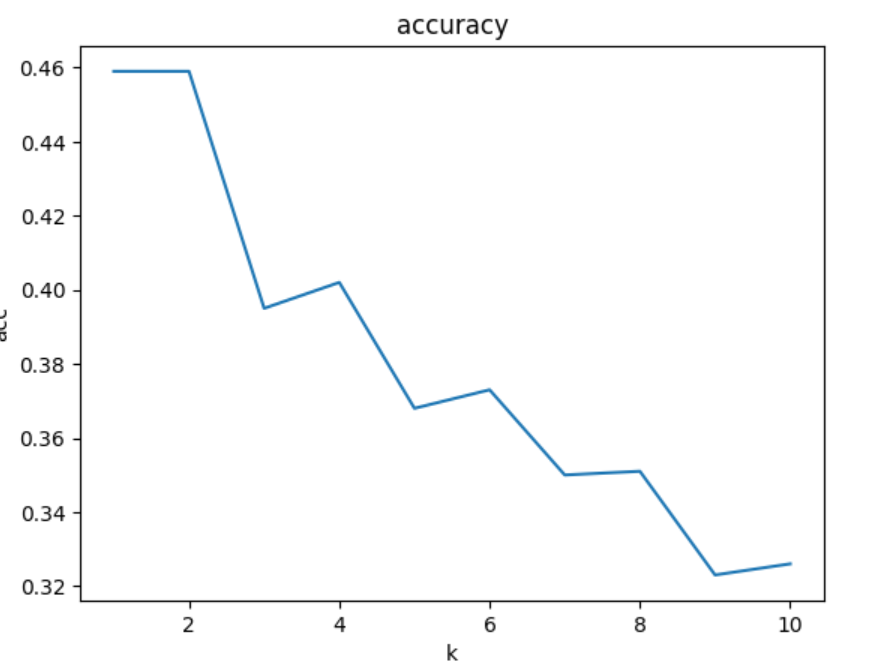



In [ ]:
import operator
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.utils.data import DataLoader

dset_path = "/content/drive/MyDrive/comp5214/pa1/mnist"

epochs = 10
batch_size = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = dsets.MNIST(root=dset_path , train=True, transform=transforms.ToTensor(),download=True, )

test_dataset = dsets.MNIST(root=dset_path ,train=False,transform=transforms.ToTensor(),download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


print("device:", device)

(60000, 784)
(60000,)
(1000, 784)
(1000,)
k =  1   accuracy:  0.459
k =  2   accuracy:  0.459
k =  3   accuracy:  0.395
k =  4   accuracy:  0.402
k =  5   accuracy:  0.368
k =  6   accuracy:  0.373
k =  7   accuracy:  0.35
k =  8   accuracy:  0.351
k =  9   accuracy:  0.323
k =  10   accuracy:  0.326


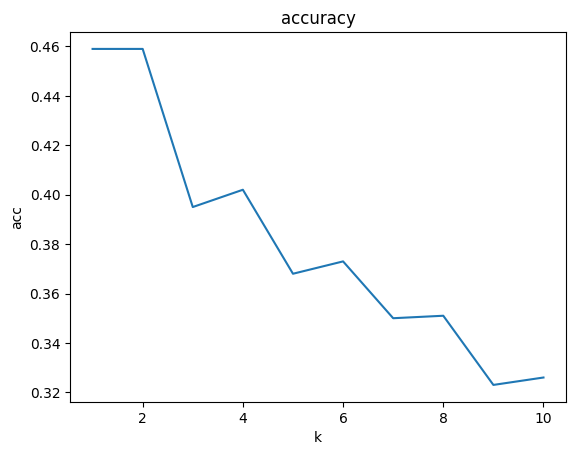

In [ ]:
def KNN(k, train_data, train_label, test_data):
    num_test = test_data.shape[0]
    label_list = []
    for i in range(num_test):
        distances = np.sum(np.abs(train_data - np.tile(test_data[i], (train_data.shape[0], 1))), axis=1)
        nearest_k = np.argsort(distances)
        top_k = nearest_k[:k]
        class_count = {}
        for j in top_k:
            class_count[train_label[j]] = class_count.get(train_label[j], 0) + 1
        sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
        label_list.append(sorted_class_count[0][0])
    return np.array(label_list)


train_data = train_loader.dataset.data.numpy()
train_data = train_data.reshape(train_data.shape[0], 28 * 28)
train_label = train_loader.dataset.targets.numpy()

test_data = test_loader.dataset.data[:1000].numpy()
test_data = test_data.reshape(test_data.shape[0], 28 * 28)
test_label = test_loader.dataset.targets[:1000].numpy()

acc = []

for k in range(1,11):
  test_label_pred = KNN(k, train_data, train_label, test_data)
  num_test = test_data.shape[0]
  num_correct = np.sum(test_label == test_label_pred)
  accuracy = float(num_correct) / num_test
  acc.append(accuracy)
  print('k = ',k,'  accuracy: ' ,accuracy)

plt.plot(range(1,11), acc)
plt.xlabel('k')
plt.ylabel('acc')
plt.title('accuracy')
plt.show()

num_neurons =  4 loss 1.14 accuracy 0.61
num_neurons =  8 loss 1.25 accuracy 0.53
num_neurons =  16 loss 0.96 accuracy 0.63
num_neurons =  32 loss 0.41 accuracy 0.85
num_neurons =  64 loss 0.39 accuracy 0.85
num_neurons =  128 loss 0.31 accuracy 0.87
num_neurons =  256 loss 0.54 accuracy 0.78


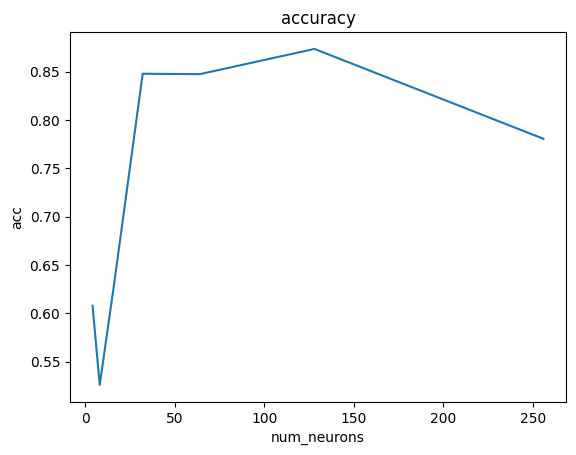

In [ ]:
### MLP
class MLP_cls(nn.Module):
    def __init__(self,num_neurons = 4, in_dim=28*28):
        super(MLP_cls,self).__init__()
        self.lin1 = nn.Linear(in_dim, num_neurons)
        self.lin2 = nn.Linear(num_neurons, num_neurons)
        self.lin3 = nn.Linear(num_neurons, num_neurons)
        self.lin4 = nn.Linear(num_neurons, 10)

        self.relu = nn.ReLU()
        init.xavier_uniform_(self.lin1.weight)
        init.xavier_uniform_(self.lin2.weight)
        init.xavier_uniform_(self.lin3.weight)
        init.xavier_uniform_(self.lin4.weight)

    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.lin4(x)
        x = self.relu(x)
        return x

epoch = 10
acc = []
nums = [4, 8, 16, 32, 64, 128,  256]
for num_neurons in nums:
  net = MLP_cls(num_neurons = num_neurons)
  optimizer = optim.Adam(net.parameters(), lr=0.0001)
  criterion = nn.CrossEntropyLoss()

  # train
  net.train()
  for epoch in range(epochs):
      run_loss = 0
      correct_num = 0
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          out = net(data)
          _,pred = torch.max(out,dim=1)
          optimizer.zero_grad()
          loss = criterion(out,target)
          loss.backward()
          run_loss += loss
          optimizer.step()
          correct_num  += torch.sum(pred==target)
      #print('epoch',epoch,'loss {:.2f}'.format(run_loss.item()/len(train_loader)),'accuracy {:.2f}'.format(correct_num.item()/(len(train_loader)*batch_size)))

  # eval
  net.eval()
  test_loss = 0
  test_correct_num = 0
  with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)
          out = net(data)
          _,pred = torch.max(out,dim=1)
          test_loss += criterion(out,target)
          test_correct_num  += torch.sum(pred==target)
  acc.append(float(test_correct_num.item()/(len(test_loader)*batch_size)))
  print("num_neurons = ", num_neurons,'loss {:.2f}'.format(test_loss.item()/len(test_loader)),'accuracy {:.2f}'.format(test_correct_num.item()/(len(test_loader)*batch_size)))

plt.plot(nums, acc)
plt.xlabel('num_neurons')
plt.ylabel('acc')
plt.title('accuracy')
plt.show()

In [ ]:
## CNN     done
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(256 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):  # with Relu
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

epoch = 5
net = CNN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

net.train()
for epoch in range(epochs):
    run_loss = 0
    correct_num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        optimizer.zero_grad()
        loss = criterion(out,target)
        loss.backward()
        run_loss += loss
        optimizer.step()
        correct_num += torch.sum(pred==target)
    print('epoch', epoch, 'loss {:.2f}'.format(run_loss.item()/len(train_loader)),'accuracy {:.2f}'.format(correct_num.item()/(len(train_loader)*batch_size)))


net.eval()
test_loss = 0
test_correct_num = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        test_loss += criterion(out,target)
        test_correct_num  += torch.sum(pred==target)
print('loss {:.2f}'.format(test_loss.item()/len(test_loader)),'accuracy {:.2f}'.format(test_correct_num.item()/(len(test_loader)*batch_size)))



epoch 0 loss 0.95 accuracy 0.75
epoch 1 loss 0.29 accuracy 0.92
epoch 2 loss 0.19 accuracy 0.94
epoch 3 loss 0.15 accuracy 0.96
epoch 4 loss 0.12 accuracy 0.96
epoch 5 loss 0.10 accuracy 0.97
epoch 6 loss 0.09 accuracy 0.97
epoch 7 loss 0.08 accuracy 0.98
epoch 8 loss 0.07 accuracy 0.98
epoch 9 loss 0.06 accuracy 0.98
loss 0.06 accuracy 0.98


In [ ]:
# CAN done   ( try other channel)
class CAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, dilation=1,padding = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,dilation=2,padding = 1 )
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3,dilation=4,padding = 1 )
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3,dilation=8 ,padding = 1)
        self.conv5 = nn.Conv2d(32, 10, kernel_size=3,dilation=1,padding = 1)
        self.pool = nn.MaxPool2d(6, 6)
        self.lrelu = nn.LeakyReLU()


    def forward(self, x):  # with Relu
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.lrelu(self.conv4(x))
        x = self.lrelu(self.conv5(x))
        x = self.pool(x)
        return x.squeeze()

net = CAN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

net.train()
for epoch in range(epochs):
    run_loss = 0
    correct_num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        #print(f"type of out {out.size()} type of tar {target.size()}")
        optimizer.zero_grad()
        loss = criterion(out,target)
        loss.backward()
        run_loss += loss
        optimizer.step()
        correct_num += torch.sum(pred==target)
    print('epoch', epoch, 'loss {:.2f}'.format(run_loss.item()/len(train_loader)),'accuracy {:.2f}'.format(correct_num.item()/(len(train_loader)*batch_size)))


net.eval()
test_loss = 0
test_correct_num = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        test_loss += criterion(out,target)
        test_correct_num  += torch.sum(pred==target)
print('loss {:.2f}'.format(test_loss.item()/len(test_loader)),'accuracy {:.2f}'.format(test_correct_num.item()/(len(test_loader)*batch_size)))



epoch 0 loss 0.80 accuracy 0.76
epoch 1 loss 0.27 accuracy 0.92
epoch 2 loss 0.22 accuracy 0.94
epoch 3 loss 0.18 accuracy 0.95
epoch 4 loss 0.16 accuracy 0.95
epoch 5 loss 0.14 accuracy 0.96
epoch 6 loss 0.12 accuracy 0.96
epoch 7 loss 0.11 accuracy 0.97
epoch 8 loss 0.10 accuracy 0.97
epoch 9 loss 0.09 accuracy 0.97
loss 0.08 accuracy 0.97


In [ ]:
# CAN done   ( try other channel)
class CAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, dilation=1,padding = 1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3,dilation=2,padding = 1 )
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3,dilation=4,padding = 1 )
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3,dilation=8 ,padding = 1)
        self.conv5 = nn.Conv2d(16, 10, kernel_size=3,dilation=1,padding = 1)
        self.pool = nn.MaxPool2d(6, 6)
        self.lrelu = nn.LeakyReLU()


    def forward(self, x):  # with Relu
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.lrelu(self.conv4(x))
        x = self.lrelu(self.conv5(x))
        x = self.pool(x)
        return x.squeeze()

net = CAN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

net.train()
for epoch in range(epochs):
    run_loss = 0
    correct_num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        #print(f"type of out {out.size()} type of tar {target.size()}")
        optimizer.zero_grad()
        loss = criterion(out,target)
        loss.backward()
        run_loss += loss
        optimizer.step()
        correct_num += torch.sum(pred==target)
    print('epoch', epoch, 'loss {:.2f}'.format(run_loss.item()/len(train_loader)),'accuracy {:.2f}'.format(correct_num.item()/(len(train_loader)*batch_size)))


net.eval()
test_loss = 0
test_correct_num = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        out = net(data)
        _,pred = torch.max(out,dim=1)
        test_loss += criterion(out,target)
        test_correct_num  += torch.sum(pred==target)
print('loss {:.2f}'.format(test_loss.item()/len(test_loader)),'accuracy {:.2f}'.format(test_correct_num.item()/(len(test_loader)*batch_size)))



epoch 0 loss 1.29 accuracy 0.61
epoch 1 loss 0.39 accuracy 0.88
epoch 2 loss 0.31 accuracy 0.91
epoch 3 loss 0.27 accuracy 0.92
epoch 4 loss 0.24 accuracy 0.93
epoch 5 loss 0.22 accuracy 0.93
epoch 6 loss 0.21 accuracy 0.94
epoch 7 loss 0.19 accuracy 0.94
epoch 8 loss 0.18 accuracy 0.95
epoch 9 loss 0.17 accuracy 0.95
loss 0.16 accuracy 0.95
